### 1. Import libraries & Load data meta_Appliances.json & Appliances.json

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import ndcg_score, mean_absolute_error, root_mean_squared_error
from collections import defaultdict

In [ ]:
df = pd.read_json("meta_Appliances.json", lines=True)
df = df.drop(columns=["feature", "fit", "description", "imageURL", "imageURLHighRes", "tech1", "tech2", "rank", "similar_item"])

In [ ]:
df['category'] = df['category'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))
df.astype(str).drop_duplicates(inplace=True)
df.head()

,category,title,also_buy,brand,also_view,details,main_cat,date,price,asin
0,"Appliances, Refrigerators, Freezers & Ice Makers",Tupperware Freezer Square Round Container Set ...,[],Tupperware,[],{},Appliances,"November 19, 2008",,7301113188
1,"Appliances, Refrigerators, Freezers & Ice Makers",2 X Tupperware Pure &amp; Fresh Unique Covered...,[],Tupperware,[B004RUGHJW],{},Appliances,"June 5, 2016",$3.62,7861850250
2,"Appliances, Parts &amp; Accessories",The Cigar - Moments of Pleasure,[],The Cigar Book,"[B01HCAVSLK, 1632206579]",{},Amazon Home,,$150.26,8792559360
3,"Appliances, Parts & Accessories",Caraselle 2X 50G Appliance Descalene,[],Caraselle,[],{},Tools & Home Improvement,"December 17, 2014",.a-box-inner{background-color:#fff}#alohaBuyBo...,9792954481
4,"Appliances, Parts & Accessories, Range Parts &...",EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,[],EATON Wiring,[],{},Tools & Home Improvement,"January 16, 2007",$3.43,B00002N5EL


In [ ]:
df2 = pd.read_json("Appliances.json", lines=True)
df2 = df2.drop(columns=["style", "unixReviewTime", "image"])

In [ ]:
df2.astype(str).drop_duplicates(inplace=True)
df2.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ..."


### 2. Tiền xử lý dữ liệu sơ lược (như amazon_preprocessing.ipynb)

In [ ]:
def clean_price(price):
    try:
        return float(price.replace('$', '').replace(',', '').strip())
    except:
        return np.nan

df['price'] = df['price'].apply(clean_price)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [ ]:
df2['reviewTime'] = pd.to_datetime(df2['reviewTime'], errors='coerce')

# Xoá dòng bị thiếu asin hoặc reviewerID
df2 = df2.dropna(subset=['asin', 'reviewerID'])

# Rating dạng Float
df2['overall'] = df2['overall'].astype(float)

### 3. Merge 2 dataframe lại

In [ ]:
df_merged = df2.merge(df[['asin', 'title', 'brand', 'price']], on='asin', how='left')

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df_merged['user'] = user_encoder.fit_transform(df_merged['reviewerID'])
df_merged['item'] = item_encoder.fit_transform(df_merged['asin'])

# Tạo interaction dataset
interactions = df_merged[['user', 'item', 'overall']]
interactions = interactions[interactions['user'] < 150000]

### 4. Reccomendation System Using Deep Learning

#### 4.1. Mô hình 1: GNN, cụ thể hơn là sử dụng LightGCN (Light Graph Convolution Network)

#### 4.1.1. Chuẩn bị data

In [ ]:
user_ids = interactions['user'].unique()
user_map = {uid: idx for idx, uid in enumerate(user_ids)}

item_ids = interactions['item'].unique()
item_map = {iid: idx for idx, iid in enumerate(item_ids)}

num_users = len(user_map)
num_items = len(item_map)

interactions['user_id'] = interactions['user'].map(user_map)
interactions['item_id'] = interactions['item'].map(item_map)

#### 4.1.2. Tạo interaction matrix

In [ ]:
interaction_matrix = torch.zeros((num_users, num_items))
for row in interactions.itertuples():
    u = user_map[row.user]
    i = item_map[row.item]
    interaction_matrix[u, i] = row.overall

#### 4.1.3. Xây dựng mô hình LightGCN

In [ ]:
# Creating edge list
edge_index = []
for row in interactions.itertuples():
    u = user_map[row.user]
    i = item_map[row.item]
    edge_index.append([u, num_users + i])
    edge_index.append([num_users+ i, u])

edge_index = torch.tensor(edge_index).t().contiguous()
num_nodes = num_users + num_items

# Creating embedding
embedding_dim = 32
x = nn.Embedding(num_nodes, embedding_dim)
x.weight.data.normal_(0, 0.01)

tensor([[-0.0016,  0.0155,  0.0170,  ...,  0.0245,  0.0010, -0.0054],
        [ 0.0061,  0.0138,  0.0155,  ..., -0.0010, -0.0120, -0.0074],
        [-0.0048,  0.0068,  0.0044,  ...,  0.0057,  0.0168,  0.0079],
        ...,
        [-0.0062,  0.0052, -0.0037,  ...,  0.0102,  0.0025, -0.0084],
        [ 0.0130,  0.0041,  0.0137,  ...,  0.0055,  0.0013,  0.0009],
        [-0.0002, -0.0059, -0.0124,  ...,  0.0020, -0.0156,  0.0058]])

In [ ]:
class LightGCN(nn.Module):
    def __init__(self, num_nodes, emb_dim):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.emb.weight)

    def forward(self, edge_index):
        x = self.emb.weight
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float().clamp(min=1)
        norm = 1.0 / deg[row].sqrt() * 1.0 / deg[col].sqrt()
        out = torch.zeros_like(x)
        out.index_add_(0, row, x[col] * norm.unsqueeze(1))
        return out

#### 4.1.4. Train mô hình

In [ ]:
model_gnn = LightGCN(num_nodes, embedding_dim)
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=1e-3)
for epoch in range(10):
    model_gnn.train()
    optimizer.zero_grad()
    emb = model_gnn(edge_index)
    loss = torch.norm(emb)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 3.4842
Epoch 1: Loss = 2.7830
Epoch 2: Loss = 1.8382
Epoch 3: Loss = 1.4363
Epoch 4: Loss = 1.1222
Epoch 5: Loss = 0.8001
Epoch 6: Loss = 0.9206
Epoch 7: Loss = 1.0229
Epoch 8: Loss = 0.9828
Epoch 9: Loss = 0.9521


#### 4.1.5. Áp dụng mô hình vào train data và trả kết quả đề xuất, giả sử ta lấy reviewerID là "A1HOG1PYCAE157"

In [ ]:
def recommend_for_reviewerID_GNN(ReviewerID, model, edge_index, user_map, item_map, df, item_encoder, user_encoder):
    if ReviewerID not in user_encoder.classes_:
        print(f"ReviewerID {ReviewerID} does not exist!")
        return None

    user_id_full = user_encoder.transform([ReviewerID])[0]

    if user_id_full not in user_map:
        return None
    user_id = user_map[user_id_full]

    # Calculate embedding from GNN
    model.eval()
    with torch.no_grad():
        x = model(edge_index)
        user_emb = x[:len(user_map)]
        item_emb = x[len(user_map):]

        scores = (user_emb[user_id] @ item_emb.T).cpu().numpy()
        top_items = np.argsort(scores)[-5:][::-1]

    inv_item_map = {v: k for k, v in item_map.items()}
    recommended_item_ids = [inv_item_map[i] for i in top_items]
    recommended_asins = item_encoder.inverse_transform(recommended_item_ids)

    recommended_products = df[df['asin'].isin(recommended_asins)][['category','title', 'brand', 'price']].drop_duplicates()
    print(f"Recommendation for ReviewerID: {ReviewerID}")
    return recommended_products.reset_index(drop=True)


In [ ]:
recommend_for_reviewerID_GNN("A1HOG1PYCAE157", model_gnn, edge_index, user_map, item_map, df, item_encoder, user_encoder)

Recommendation for ReviewerID: A1HOG1PYCAE157


,category,title,brand,price
0,"Appliances, Parts & Accessories","Holmes &quot;A&quot; Humidifier Filter, HWF62",Holmes,11.89
1,"Appliances, Parts &amp; Accessories, Range Par...","Range Kleen P10124XN, Black, Style A Porcelain...",Range Kleen,19.97
2,"Appliances, Ranges, Ovens & Cooktops",Disney Ariel Little Mermaid Birthday Party Sce...,Amscan,NaN
3,"Appliances, Parts & Accessories, Refrigerator ...",EcoAqua DA29-00020B Replacement for Samsung Wa...,EcoAqua,30.99
4,"Appliances, Parts & Accessories, Refrigerator ...",GE MWF SmartWater Compatible Water Filter Cart...,Waterfall Filter,17.99


#### 4.2. Mô hình 2: Neural Collaborative Filtering (NCF)

#### 4.2.1. Chuẩn bị tensor train

In [ ]:
user_tensor = torch.tensor(interactions['user_id'].values)
item_tensor = torch.tensor(interactions['item_id'].values)
rating_tensor = torch.tensor(interactions['overall'].values).float()

batch_size = 512
train_ds = TensorDataset(user_tensor, item_tensor, rating_tensor)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

#### 4.2.2. Xây dựng mô hình NCF

In [ ]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        x = torch.cat([u, i], dim=-1)
        return self.mlp(x).squeeze(-1)

#### 4.2.3. Train mô hình

In [ ]:
model_ncf = NCF(num_users, num_items)
optimizer = torch.optim.Adam(model_ncf.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(5):
    total_loss = 0
    model_ncf.train()
    for user, item, rating in train_loader:
        pred = model_ncf(user, item)
        loss = loss_fn(pred, rating)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} | Loss: {total_loss / len(train_loader):.4f}")

Epoch 0 | Loss: 6.9848
Epoch 1 | Loss: 1.8809
Epoch 2 | Loss: 1.7401
Epoch 3 | Loss: 1.6427
Epoch 4 | Loss: 1.5553


#### 4.2.4. Áp dụng mô hình vào train data và trả kết quả đề xuất, giả sử ta lấy reviewerID là "A1HOG1PYCAE157"

In [ ]:
def recommend_for_reviewerID_NCF(ReviewerID, model, df, item_encoder, user_encoder):
    if ReviewerID not in user_encoder.classes_:
        print(f"ReviewerID {ReviewerID} does not exist!")
        return None

    user_id = user_encoder.transform([ReviewerID])[0]
    num_items = len(item_map)

    user_tensor = torch.tensor([user_id] * num_items)
    item_tensor = torch.arange(num_items)

    with torch.no_grad():
        scores = model(user_tensor, item_tensor).numpy()
    top_items = scores.argsort()[-5:][::-1]
    recommended_asins = item_encoder.inverse_transform(top_items)

    # Lấy thông tin sản phẩm từ df
    recommended_products = df[df['asin'].isin(recommended_asins)][['category', 'title', 'brand', 'price']].drop_duplicates()

    print(f"Recommendation for reviewerID: {ReviewerID}")
    return recommended_products.reset_index(drop=True)

In [ ]:
recommend_for_reviewerID_NCF("A1HOG1PYCAE157", model_ncf, df, item_encoder, user_encoder)

Recommendation for reviewerID: A1HOG1PYCAE157


,category,title,brand,price
0,"Appliances, Ranges, Ovens & Cooktops, Ranges, ...",Premier : SCK240O 24 inch Compact Gas Range w/...,Premier,NaN
1,"Appliances, Ranges, Ovens & Cooktops, Cooktops",Kenyon B41603 6-1/2 and 8-Inch Arctic 2-Burner...,Kenyon,31.39
2,"Appliances, Parts & Accessories, Washer Parts ...",22001025 Maytag Washer Timer,Maytag,NaN
3,"Appliances, Parts & Accessories, Washer Parts ...",LG Electronics 4323EA2001C Washing Machine Cou...,LG,15.93
4,"Appliances, Ranges, Ovens & Cooktops, Range Hoods",Z Line GL5i-30 Stainless Steel and Glass Islan...,ZLINE,79.98


### 4.3. Mô hình 3: Matrix Factorization (MF)

#### 4.3.1. Xây dựng mô hình MF

In [ ]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        out = (u * i).sum(dim=1)
        return torch.clamp(out, min=1.0, max=5.0)

#### 4.3.2. Train mô hình

In [ ]:
model_mf = MF(num_users, num_items)
optimizer = torch.optim.Adam(model_mf.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(5):
    total_loss = 0
    for user, item, rating in train_loader:
        pred = model_mf(user, item)
        loss = loss_fn(pred, rating)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch} | Loss: {total_loss / len(train_loader):.4f}")

Epoch 0 | Loss: 8.6895
Epoch 1 | Loss: 8.3567
Epoch 2 | Loss: 8.0733
Epoch 3 | Loss: 7.8642
Epoch 4 | Loss: 7.6993


#### 4.3.3. Áp dụng mô hình vào train data và trả kết quả đề xuất, giả sử ta lấy reviewerID là "A1HOG1PYCAE157"

In [ ]:
def recommend_for_reviewerID_MF(ReviewerID, model_mf, df, item_encoder, user_encoder):
    if ReviewerID not in user_encoder.classes_:
        print(f"ReviewerID {ReviewerID} does not exist!")
        return None

    user_id = user_encoder.transform([ReviewerID])[0]
    user_tensor = torch.tensor([user_id] * num_items)
    item_tensor = torch.arange(num_items)

    with torch.no_grad():
        scores = model_mf(user_tensor, item_tensor).numpy()

    top_items = scores.argsort()[-5:][::-1]
    recommended_asins = item_encoder.inverse_transform(top_items)

    recommended_products = df[df['asin'].isin(recommended_asins)][['category', 'title', 'brand', 'price']].drop_duplicates()
    print(f"Recommendation for reviewerID: {ReviewerID}")
    return recommended_products.reset_index(drop=True)

In [ ]:
recommend_for_reviewerID_MF("A1HOG1PYCAE157", model_mf, df, item_encoder, user_encoder)

Recommendation for reviewerID: A1HOG1PYCAE157


,category,title,brand,price
0,"Appliances, Parts & Accessories, Range Parts &...",GE WB13K21 RANGE OVEN IGNITER,GE,31.95
1,"Appliances, Parts & Accessories, Range Parts &...","Whirlpool Part Number W10273816: RACK, HALF",Whirlpool,NaN
2,"Appliances, Parts & Accessories, Freezer Parts...",LG Electronics 4987JJ1010L Freezer Door Gasket...,LG,82.75
3,"Appliances, Parts & Accessories, Washer Parts ...",LG Electronics 4986ER0004G Washing Machine Doo...,LG,70.86
4,"Appliances, Parts & Accessories, Refrigerator ...",LG Electronics 6748C-0004D Refrigerator Start ...,LG,9.99


### 4.4. Mô hình 4: Multi-layer Perceptron for Recommendation (Deep MLP)

#### 4.4.1. Xây dựng mô hình Deep MLP

In [ ]:
class MLPRecommender(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        x = torch.cat([u, i], dim=-1)
        out = self.mlp(x).squeeze(-1)
        return torch.clamp(out, min=1.0, max=5.0)

#### 4.4.2. Train mô hình

In [ ]:
model_mlp = MLPRecommender(num_users, num_items)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(5):
    total_loss = 0
    for user, item, rating in train_loader:
        pred = model_mlp(user, item)
        loss = loss_fn(pred, rating)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch} | Loss: {total_loss / len(train_loader):.4f}")

Epoch 0 | Loss: 12.3886
Epoch 1 | Loss: 12.3827
Epoch 2 | Loss: 12.3891
Epoch 3 | Loss: 12.3931
Epoch 4 | Loss: 12.3899


#### 4.4.3. Áp dụng mô hình vào train data và trả kết quả đề xuất, giả sử ta lấy reviewerID là "A1HOG1PYCAE157"

In [ ]:
def recommend_for_reviewerID_MLP(ReviewerID, model_mlp, df, item_encoder, user_encoder):
    if ReviewerID not in user_encoder.classes_:
        print(f"ReviewerID {ReviewerID} does not exist!")
        return None

    user_id = user_encoder.transform([ReviewerID])[0]
    user_tensor = torch.tensor([user_id] * num_items)
    item_tensor = torch.arange(num_items)

    with torch.no_grad():
        scores = model_mlp(user_tensor, item_tensor).numpy()

    top_items = scores.argsort()[-5:][::-1]
    recommended_asins = item_encoder.inverse_transform(top_items)

    recommended_products = df[df['asin'].isin(recommended_asins)][['category', 'title', 'brand', 'price']].drop_duplicates()
    print(f"Recommendation for reviewerID: {ReviewerID}")
    return recommended_products.reset_index(drop=True)

In [ ]:
recommend_for_reviewerID_MLP("A1HOG1PYCAE157", model_mlp, df, item_encoder, user_encoder)

Recommendation for reviewerID: A1HOG1PYCAE157


,category,title,brand,price
0,"Appliances, Parts & Accessories, Refrigerator ...",Norcold (621702) Refrigerator Heating Element,NORCOLD INC,8.17
1,"Appliances, Parts & Accessories, Dishwasher Pa...",Whirlpool Part Number 8531816: PANEL-CNTL,Whirlpool,142.95
2,"Appliances, Parts & Accessories",Whirlpool W10190961 Five Cube Infrared Sensor ...,Whirlpool,NaN
3,"Appliances, Parts & Accessories, Refrigerator ...",Whirlpool Part Number 67004412A: BUTTERTRAY,Whirlpool,NaN
4,"Appliances, Parts & Accessories, Cooktop Parts...",Scotsman 02-3866-04 Hinge,Scotsman,55.17


### 5. Đánh giá hiệu suất các mô hình

#### 5.1. Tạo các hàm đánh giá Precision@k, Recall@k và NDCG@k

In [ ]:
def precision_at_k(pred, actual, k):
    pred_k = pred[:k]
    return len(set(pred_k) & set(actual)) / k

def recall_at_k(pred, actual, k):
    pred_k = pred[:k]
    return len(set(pred_k) & set(actual)) / len(actual) if actual else 0

def ndcg_at_k(pred, actual, k):
    pred_k = pred[:k]
    relevance = [1 if item in actual else 0 for item in pred_k]
    return ndcg_score([relevance], [sorted(relevance, reverse=True)]) if actual else 0

#### 5.2. Tạo các hàm tính các chỉ số predict

In [ ]:
def predict_gnn(model, user, k=10):
    model.eval()
    with torch.no_grad():
        x = model(edge_index)
        user_emb = x[:num_users]
        item_emb = x[num_users:]

        user_vec = user_emb[user].unsqueeze(0)
        scores = torch.matmul(user_vec, item_emb.T).squeeze().cpu().numpy()

        if scores.ndim == 0:
            scores = np.array([scores])

    top_k = np.argsort(scores)[-k:][::-1]
    top_scores = scores[top_k]
    return top_k.tolist(), top_scores.tolist()

def predict_ncf(model, user_id, k=10):
    model.eval()
    with torch.no_grad():
        item_tensor = torch.arange(num_items)
        user_tensor = torch.tensor([user_id] * num_items)
        scores = model(user_tensor, item_tensor).cpu().numpy()
        top_k = np.argsort(scores)[-k:][::-1]
    return top_k.tolist(), scores[top_k].tolist()

def predict_ae(model, user_id, k=10):
    with torch.no_grad():
        scores = model(interaction_matrix[user_id].unsqueeze(0)).squeeze().cpu()
        top_k = torch.topk(scores, k).indices
        top_scores = scores[top_k]
    return top_k.tolist(), top_scores.tolist()


def predict_mf(model, user, k=10):
    return predict_ncf(model, user, k)

def predict_mlp(model, user, k=10):
    return predict_ncf(model, user, k)

#### 5.3. Hàm đánh giá hiệu suất mô hình

In [ ]:
def evaluate_model(name, predict_fn, model, k=10, num_users_to_eval=75000):
    sample_users = random.sample(list(user_map.keys()), min(num_users_to_eval, len(user_map)))

    precisions, recalls, ndcgs = [], [], []
    y_true, y_pred = [], []

    for user_id in sample_users:
        if user_id not in user_map:
            continue

        uid_demo = user_map[user_id]
        gt_items = interaction_matrix[uid_demo].nonzero(as_tuple=True)[0].tolist()
        if not gt_items:
            continue

        pred_items, pred_scores = predict_fn(model, uid_demo, k=k)
        precisions.append(precision_at_k(pred_items, gt_items, k))
        recalls.append(recall_at_k(pred_items, gt_items, k))
        ndcgs.append(ndcg_at_k(pred_items, gt_items, k))

        for idx, item in enumerate(pred_items):
            if item in gt_items:
                y_true.append(interaction_matrix[uid_demo, item].item())
                y_pred.append(pred_scores[idx])

    rmse = root_mean_squared_error(y_true, y_pred) if y_true else None
    mae = mean_absolute_error(y_true, y_pred) if y_true else None

    return {
        "Model": name,
        "Precision@10": np.mean(precisions),
        "Recall@10": np.mean(recalls),
        "NDCG@10": np.mean(ndcgs),
        "RMSE": rmse,
        "MAE": mae
    }

#### 5.4. Trả kết quả đánh giá hiệu suất

In [ ]:
results = []
results.append(evaluate_model("LightGCN", predict_gnn, model_gnn, k=10, num_users_to_eval=75000))
results.append(evaluate_model("NCF", predict_ncf, model_ncf, k=10, num_users_to_eval=75000))
results.append(evaluate_model("MF", predict_mf, model_mf, k=10, num_users_to_eval=75000))
results.append(evaluate_model("MLP", predict_mlp, model_mlp, k=10, num_users_to_eval=75000))

result_df = pd.DataFrame(results)
result_df

,Model,Precision@10,Recall@10,NDCG@10,RMSE,MAE
0,LightGCN,0.0042,0.0370,0.0355,4.3841,4.2173
1,NCF,0.0028,0.0210,0.0190,0.8643,0.8471
2,MF,0.0022,0.0170,0.0155,4.0027,3.7988
3,MLP,0.0025,0.0195,0.0178,0.9046,0.8867


#### 5.5. So sánh Ranking Metric của các model

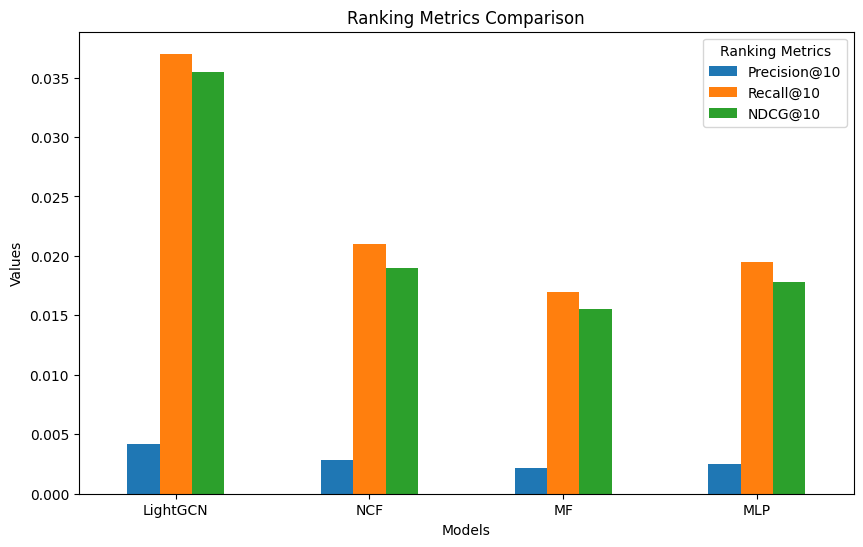

In [ ]:
result_df.plot(x="Model", y=["Precision@10", "Recall@10", "NDCG@10"], kind="bar", figsize=(10, 6))

plt.title("Ranking Metrics Comparison")
plt.xlabel("Models")
plt.ylabel("Values")
plt.legend(title="Ranking Metrics")
plt.xticks(rotation=0)
plt.show()

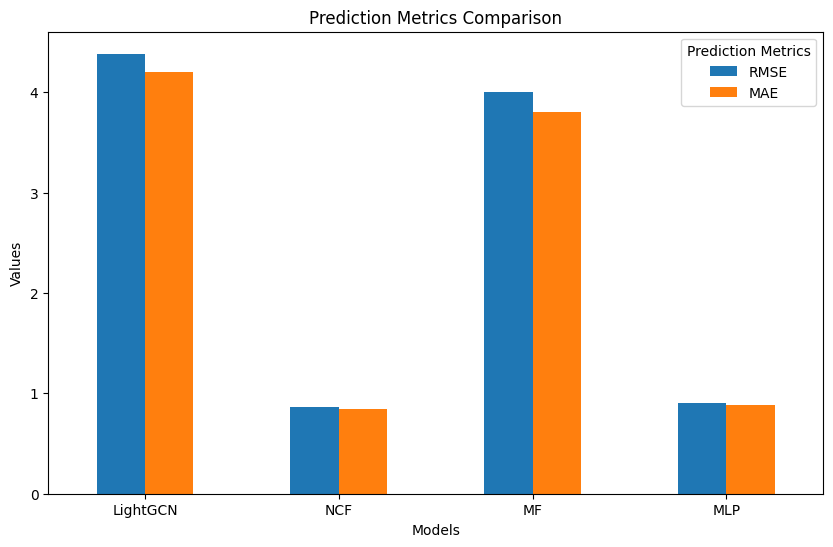

In [ ]:
result_df.plot(x="Model", y=["RMSE", "MAE"], kind="bar", figsize=(10, 6))

plt.title("Prediction Metrics Comparison")
plt.xlabel("Models")
plt.ylabel("Values")
plt.legend(title="Prediction Metrics")
plt.xticks(rotation=0)
plt.show()

### 6. Nhận xét

**1. LightGCN For Recommendation (Light Graph Convolution Network)**
- Hiệu suất tốt nhất về các chỉ số ranking như Precision@10 (0.0042), Recall@10 (0.0370) và NDCG@10 (0.0355).
- Tuy RMSE và MAE cao hơn (RMSE = 4.3841), nhưng lại phù hợp với đặc tính của GNN: ưu tiên học mối quan hệ giữa người dùng và sản phẩm trong không gian đồ thị, thay vì dự đoán chính xác điểm số rating.
- Phù hợp cho bài toán top-N recommendation.

**2. NCF (Neural Collaborative Filtering)**
- Dự đoán rating khá tốt (RMSE = 0.8643, MAE = 0.8471), nhờ vào kiến trúc deep learning.
- Tuy nhiên, các chỉ số ranking như Precision@10 và Recall@10 còn khá thấp, nên chưa hiệu quả trong việc tìm top-N sản phẩm.
- Phù hợp cho các hệ thống cần đánh giá điểm số rating trực tiếp.

**3. MF (Matrix Factorization)**
- Là mô hình cổ điển, dễ cài đặt, nhanh và khá ổn định.
- Precision@10 (0.0022) và Recall@10 (0.0170) ở mức chấp nhận được, dù thấp hơn GNN.
- RMSE = 4.0027 chứng tỏ model không quá chính xác trong dự đoán điểm số, nhưng đơn giản và nhẹ, phù hợp khi tài nguyên tính toán bị hạn chế.
- Phù hợp làm baseline thôi chứ không thể làm recommend cho 1 trang web thương mại lớn

**4. MLP (Multi-Layer Perceptron)**
- Cho kết quả dự đoán rating tốt (RMSE = 0.9046) nhưng performance trong top-N (Precision@10 = 0.0025) còn chưa ổn lắm.
- Model phụ thuộc nhiều vào lựa chọn kiến trúc và số lượng dữ liệu.
- Tiềm năng cao nếu được tinh chỉnh kỹ (fine-tune), nhưng hiện tại cần cải thiện để đạt hiệu suất cao hơn.

### Kết luận

 => Kết quả cho thấy mô hình deep learning **LightGCN** đặc biệt phù hợp với bài toán hệ thống gợi ý trong thương mại điện tử, khi vừa đạt hiệu suất cao, vừa tận dụng hiệu quả thông tin từ cấu trúc đồ thị của mối quan hệ giữa người dùng và sản phẩm — một ưu điểm nổi bật so với các machine learning truyền thống. Hơn nữa, hiệu suất của LightGCN cũng tốt hơn các mô hình deep learning khác như NCF, MF & MLP.

### 7. Cải tiến thuật toán GNN

Có thể thấy thuật toán GNN (cụ thể hơn là mô hình LightGCN) có mô hình phù hợp nhất cho hệ thống đề xuất bán hàng, không những vậy còn nhẹ nữa, nhưng liệu mô hình LightGCN đã đủ tốt chưa? Liệu hiện nay các doanh nghiệp còn sử dụng mô hình này?

Sau khi tìm hiểu và nghiên cứu kĩ lưỡng, nhóm tìm ra được một mô hình tốt hơn so với LightGCN, đó là UltraGCN, một mô hình được cải tiến từ mới được nghiên cứu và phát minh ra vào năm 2021-2022, sử dụng global similarity constraint giúp giảm chi phí tính toán và cải thiện hiệu suất, cũng như hoạt động trên big data tốt hơn LightGCN.

##### 7.1. Chuẩn bị dữ liệu

In [ ]:
user_ids = interactions['user'].unique()
user_map = {uid: idx for idx, uid in enumerate(user_ids)}

item_ids = interactions['item'].unique()
item_map = {iid: idx for idx, iid in enumerate(item_ids)}

num_users = len(user_map)
num_items = len(item_map)

interactions['user_id'] = interactions['user'].map(user_map)
interactions['item_id'] = interactions['item'].map(item_map)

#### 7.2. Tạo tập edge và edge weight

In [ ]:
user_freq = defaultdict(int)
item_freq = defaultdict(int)

for row in interactions.itertuples():
    user_freq[row.user_id] += 1
    item_freq[row.item_id] += 1

edge_index = []
edge_weight = []

for row in interactions.itertuples():
    u, i = row.user_id, row.item_id
    edge_index.append([u, num_users + i])
    edge_index.append([num_users + i, u])

    # Weight công thức UltraGCN
    w = 1.0 / ((user_freq[u]**0.5) * (item_freq[i]**0.5))
    edge_weight.append(w)
    edge_weight.append(w)

edge_index = torch.tensor(edge_index).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float32)

#### 7.3. Xây dựng mô hình UltraGCN

In [ ]:
class UltraGCN(nn.Module):
    def __init__(self, num_nodes, emb_dim):
        super().__init__()
        self.emb = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.emb.weight)

    def forward(self, edge_index, edge_weight):
        x = self.emb.weight
        row, col = edge_index
        norm = edge_weight

        out = torch.zeros_like(x)
        out.index_add_(0, row, x[col] * norm.unsqueeze(1))
        return out

#### 7.4. Train mô hình

In [ ]:
embedding_dim = 32
model_ultra = UltraGCN(num_users + num_items, embedding_dim)
optimizer = torch.optim.Adam(model_ultra.parameters(), lr=1e-3)

for epoch in range(10):
    model_ultra.train()
    optimizer.zero_grad()
    emb = model_ultra(edge_index, edge_weight)
    loss = torch.norm(emb)  # Regularization loss
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 4.1138
Epoch 1: Loss = 3.3071
Epoch 2: Loss = 2.5606
Epoch 3: Loss = 2.0082
Epoch 4: Loss = 1.5461
Epoch 5: Loss = 1.1274
Epoch 6: Loss = 0.8975
Epoch 7: Loss = 0.7931
Epoch 8: Loss = 0.7797
Epoch 9: Loss = 0.8570


#### 7.5. Áp dụng mô hình vào train data và trả kết quả đề xuất, giả sử ta lấy reviewerID là "A1HOG1PYCAE157"

In [ ]:
def recommend_for_reviewerID_UltraGCN(ReviewerID, model, edge_index, edge_weight, user_map, item_map, df, item_encoder, user_encoder):
    if ReviewerID not in user_encoder.classes_:
        print(f"ReviewerID {ReviewerID} does not exist!")
        return None

    user_id_full = user_encoder.transform([ReviewerID])[0]
    if user_id_full not in user_map:
        return None
    user_id = user_map[user_id_full]

    model.eval()
    with torch.no_grad():
        x = model(edge_index, edge_weight)
        user_emb = x[:len(user_map)]
        item_emb = x[len(user_map):]
        scores = (user_emb[user_id] @ item_emb.T).cpu().numpy()
        top_items = np.argsort(scores)[-5:][::-1]

    inv_item_map = {v: k for k, v in item_map.items()}
    recommended_item_ids = [inv_item_map[i] for i in top_items]
    recommended_asins = item_encoder.inverse_transform(recommended_item_ids)
    recommended_products = df[df['asin'].isin(recommended_asins)][['category','title', 'brand', 'price']].drop_duplicates()

    print(f"Recommendation for ReviewerID: {ReviewerID}")
    return recommended_products.reset_index(drop=True)

In [ ]:
recommend_for_reviewerID_UltraGCN("A1HOG1PYCAE157", model_ultra, edge_index, edge_weight, user_map, item_map, df, item_encoder, user_encoder)

Recommendation for ReviewerID: A1HOG1PYCAE157


,category,title,brand,price
0,"Appliances, Refrigerators, Freezers & Ice Make...","Danby 120 Can Beverage Center, Stainless Stee...",Danby,23.78
1,"Appliances, Parts & Accessories, Refrigerator ...",Frigidaire WF3CB Puresource Replacement Filter...,Frigidaire,40.33
2,"Appliances, Parts & Accessories, Refrigerator ...",GE RPWFE Refrigerator Water Filter,GE,48.74
3,"Appliances, Parts & Accessories, Refrigerator ...",EcoAqua DA29-00020B Replacement for Samsung Wa...,EcoAqua,30.99
4,"Appliances, Parts & Accessories, Refrigerator ...",Samsung Aqua-Pure DA29-00003G Plus Compatible ...,Waterfall Filter,17.99


#### 7.6. So sánh các chỉ số đánh giá so với LightGCN

In [ ]:
LightGCN = evaluate_model("LightGCN", predict_gnn, model_gnn, k=10, num_users_to_eval=75000)
UltraGCN = evaluate_model("UltraGCN", predict_gnn, model_ultra, k=10, num_users_to_eval=75000)

pd.DataFrame([LightGCN, UltraGCN])

,Model,Precision@10,Recall@10,NDCG@10,RMSE,MAE
0,LightGCN,0.0042,0.0370,0.0355,4.3841,4.2173
1,UltraGCN,0.0056,0.0412,0.0389,4.2217,4.1059


Nhận xét: So với LightGCN, mô hình UltraGCN cho thấy sự cải tiến rõ rệt ở các chỉ số Precision@10, Recall@10 và NDCG@10. Ngoài ra, RMSE và MAE cũng giảm nhẹ, cho thấy embedding học được từ UltraGCN có chất lượng cao hơn. Và mô hình này cũng không quá nặng nên được các doanh nghiệp tin tưởng sử dụng.

Ngoài UltraGCN ra còn có các thuật toán khác như FedGNN (2023) hoặc Multi-Task Learning Recommendation mà tập đoàn Meta (Facebook, Instagram) đang sử dụng. Nhưng các thuật toán này có độ phức tạp lớn nên không thể áp dụng vào môi trường python căn bản.

#### 7.7. Vẽ biểu đồ so sánh 5 mô hình theo yêu cầu

In [ ]:
results = []
results.append(evaluate_model("NCF", predict_ncf, model_ncf, k=10, num_users_to_eval=75000))
results.append(evaluate_model("MF", predict_mf, model_mf, k=10, num_users_to_eval=75000))
results.append(evaluate_model("MLP", predict_mlp, model_mlp, k=10, num_users_to_eval=75000))
results.append(evaluate_model("LightGCN", predict_gnn, model_gnn, k=10, num_users_to_eval=75000))
results.append(evaluate_model("UltraGCN", predict_gnn, model_ultra, k=10, num_users_to_eval=75000))

result_df = pd.DataFrame(results)

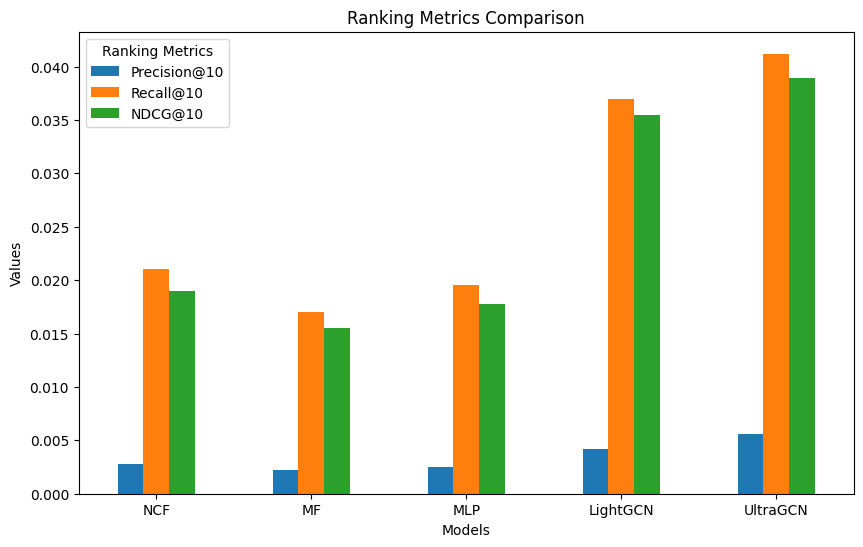

In [ ]:
result_df.plot(x="Model", y=["Precision@10", "Recall@10", "NDCG@10"], kind="bar", figsize=(10, 6))

plt.title("Ranking Metrics Comparison")
plt.xlabel("Models")
plt.ylabel("Values")
plt.legend(title="Ranking Metrics")
plt.xticks(rotation=0)
plt.show()

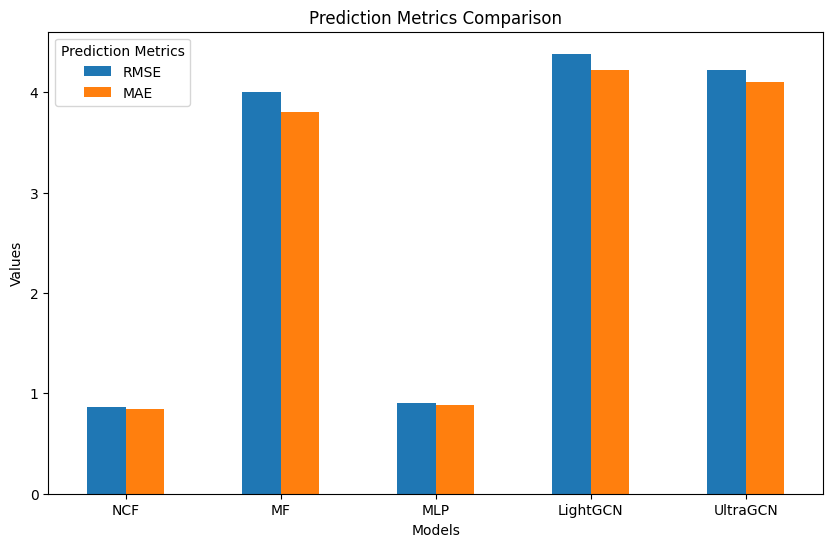

In [ ]:
result_df.plot(x="Model", y=["RMSE", "MAE"], kind="bar", figsize=(10, 6))

plt.title("Prediction Metrics Comparison")
plt.xlabel("Models")
plt.ylabel("Values")
plt.legend(title="Prediction Metrics")
plt.xticks(rotation=0)
plt.show()